# Automatic Waste Segregator: CNN for Real-World Application
This Notebook assumed pre-knowledge about how CNN works, Numpy, Pandas and how to code a basic CNN for classifying MNIST Numbers. The matplotlib functions have self-explanatory names and do not need much delving into

In [ ]:
! git clone https://github.com/RishiNandha/AWS

Cloning into 'AWS'...
remote: Enumerating objects: 2704, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 2704 (delta 76), reused 149 (delta 76), pack-reused 2555
Receiving objects: 100% (2704/2704), 493.13 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Updating files: 100% (2427/2427), done.


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Dropout, SpatialDropout2D, AveragePooling2D
import numpy as np
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, show, imshow
import cv2
from keras.preprocessing.image import ImageDataGenerator

os.chdir('AWS')

## Dataset Preprocessing
This is where we prepare the Training Set and the Validation Set

### Challenges in any Real-World CNN Application

We have a dataset of 1995 Images. This has two challenges:

1. We cannot load the entire data into one numpy array in one shot. This will require the computer to allocate RAM to Python in the order of GBs

2. 1995 Datapoints is a very small number to get good accuracies from.

### 1. Lazy-Loading

The first challenged is solved by "Lazy-Loading" the data. That is, the Data isn't loaded into a Numpy Array at the start of the program itself, instead we define a `flow_from_directory()` which takes the images from the given folder only when required.

The folder has to have subfolders with names corresponding to the Class of the image, with images inside these subfolders

### 2. Data Augmentation

The second challenge is mitigate by randomizing transformations on the existing images to form new images. For example, a cat's image slightly rotated is still a cat. This is done using `ImageDataGenerator()`.

Note that these transforms should be done only to a sensible extent



In [ ]:
batchsize = 32
# Data Augmentation

train_datagen = ImageDataGenerator(
   	shear_range=0.1,	height_shift_range=0.2,
        zoom_range=0.2,     horizontal_flip=True,
        vertical_flip=True, width_shift_range=0.2)

# Lazy Loading

train_generator = train_datagen.flow_from_directory(
        'train',           target_size=(256, 256),
        batch_size=batchsize,      class_mode='categorical')

Found 1995 images belonging to 6 classes.


### 3. Validation Split
Having a Validation Set other than just Training and Testing is important. This is because adding Validation Accuracy as a Metric allows us to track for Underfitting and Overfitting. This also allows us to set an arbitrarily large number of Epochs and "Checkpoint the Training" & "Early Stop the Training" (Discussed later)

**Underfitting** - Both Training accuracy and Validation accuracy saturate to a small value

**Overfitting** - Training accuracy gets unrealistically good but the Validation accuracy either stops increasing or starts decreasing

There are pre-defined methods to do the Validation Split too but below is a demonstration of how to manually prepare a dataset. The output layer predicts a numpy array of probabilities, so the ideal predictions that we train the model to should be numpy arrays with `1` in the index corresponding to the right class and `0` everywhere else, length matched with the size of the output layer


The pre-defined method would be much faster than this ofcourse

In [ ]:
# os.chdir() sets the current folder
os.chdir('predb')

# Empty Numpy Arrays initialized to start appending data into

y_val = np.array([]).reshape((0,6))
x_val = np.array([]).reshape((0,256,256,3))

# Encoding in the right format to be matched against Output Layer

def encode_class(x):
	l = [0 for i in range(6)]
	l[x]=1
	return np.array(l).reshape((1,6))

def load_data(name):
	global x_val
	global y_val

    # x = 5 for "Mixed"

	x=5

    # Re-sizing Images to match Input Layer

	image = plt.imread(name)
	image = cv2.resize(image,(256,256))

	x_val = np.append(x_val, image.reshape((1,256,256,3)),axis=0)

    # In the predb folder, images have been named according to their classes.
    # So this is checking if the class names are a substring of filename

	if 'cardboard' in name:
		x=0
	elif 'glass' in name:
		x=1
	elif 'metal' in name:
		x=2
	elif 'paper' in name:
		x=3
	elif 'plastic' in name:
		x=4

	y_val = np.append(y_val, encode_class(x),axis=0)

# os.listdir() lists all filenames and folders in the current folder

for i in os.listdir()[1:]:
	load_data(i)

print(x_val.shape, '\t', y_val.shape)
os.chdir("..")

(406, 256, 256, 3) 	 (406, 6)


## Model Definition
This is where the educated guessing of what works goes.

**Underfit:** We can either increase the number of layers or increase the size of layers or decrease the learning rate

**Overfit:** We can either decrease the number of layers or decrease the size of layers or add dropout layers if its over-fitting



In [ ]:
# Model

# Rishi's Model
layerz = [Conv2D(72, kernel_size=(3,3), input_shape=(256,256,3)),
		Conv2D(72, kernel_size=(3,3),activation='relu'),
		MaxPooling2D(pool_size=(2,2)),
		Conv2D(72, kernel_size=(3,3)),
		Conv2D(72, kernel_size=(3,3),activation='relu'),
		MaxPooling2D(pool_size=(2,2)),
		Conv2D(72, kernel_size=(3,3)),
		Conv2D(72, kernel_size=(3,3),activation='relu'),
		MaxPooling2D(pool_size=(2,2)),
		Flatten(),
		Dense(250, activation='relu'),
		Dense(6,activation='softmax')]

# AM's model
# layerz = [Conv2D(128,(3,3),input_shape=(256,256,3), activation='relu'),
# 		MaxPooling2D(pool_size=2),
# 		Conv2D(32,(3,3),activation='relu'),
# 		MaxPooling2D(pool_size=2),
# 		Flatten(),
# 		Dense(512,activation='relu'),
# 		Dropout(0.2),
# 		Dense(6,activation='softmax')]

# Afeefa's Model
# layerz = []

model=keras.Sequential(layerz)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0000020*batchsize), metrics=['accuracy'])

## Training Callbacks
The two useful training callbacks we mentioned earlier are "Checkpoint" and "Early Stopping"

### 1. Checkpoint

The model can be asked to save the best weights that's been encounter so far into a `hdf5` file. "Best" is decided using the validation accuracy.

This allows the model to save only up until where the training is still favourable and ignores the changes once over-fitting starts.

This also allows to repeatly run the same code to train further using a `try:` statement whenever a `hdf5` file already exists

This also allows us to keyboard interrupt training and still have the most recent set of weights

### 2. Early Stopping

The model can be asked to stop training after waiting for a `patience`-number of epochs. This is done so that the program stops after underfitting or overfitting starts and doesn't waste time running for more

In [ ]:
# Checkpoint

checkpoint = keras.callbacks.ModelCheckpoint('ckpt.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early Stopping

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

try:
    model.load_weights('ckpt.hdf5')
except:
    print("No Pre-existing Checkpoint, creating new one")

No Pre-existing Checkpoint, creating new one


## Training

Finally, here goes Training

In [7]:
model.fit(
        train_generator, steps_per_epoch=1995//batchsize,
        epochs=100, validation_data=(x_val,y_val), callbacks=[checkpoint, stop])

model.save("AWS")

Epoch 1/100
110/110 [==============================] - ETA: 0s - loss: 7.0555 - accuracy: 0.3305
Epoch 1: val_accuracy improved from -inf to 0.45074, saving model to ckpt.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


110/110 [==============================] - 60s 437ms/step - loss: 7.0555 - accuracy: 0.3305 - val_loss: 1.4420 - val_accuracy: 0.4507
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 1.4034 - accuracy: 0.4222
Epoch 2: val_accuracy did not improve from 0.45074
110/110 [==============================] - 33s 302ms/step - loss: 1.4034 - accuracy: 0.4222 - val_loss: 1.3883 - val_accuracy: 0.4507
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 1.3580 - accuracy: 0.4644
Epoch 3: val_accuracy improved from 0.45074 to 0.49507, saving model to ckpt.hdf5
110/110 [==============================] - 35s 315ms/step - loss: 1.3580 - accuracy: 0.4644 - val_loss: 1.2140 - val_accuracy: 0.4951
Epoch 4/100
110/110 [==============================] - ETA: 0s - loss: 1.2776 - accuracy: 0.4917
Epoch 4: val_accuracy improved from 0.49507 to 0.53941, saving model to ckpt.hdf5
110/110 [==============================] - 35s 313ms/step - loss: 1.2776 - accuracy: 0.4917 

## Showtime: Testing
Here's a loop that picks an image, shows what it is and then runs the model on it. `model(img)` just sends the `img` through the model as if `model()` was a function and returns the output layer's values as a numpy array. Rest of the code is just formatting it for displaying

 

Enter Test Image Index (Enter an Integer lesser than 407) : 350


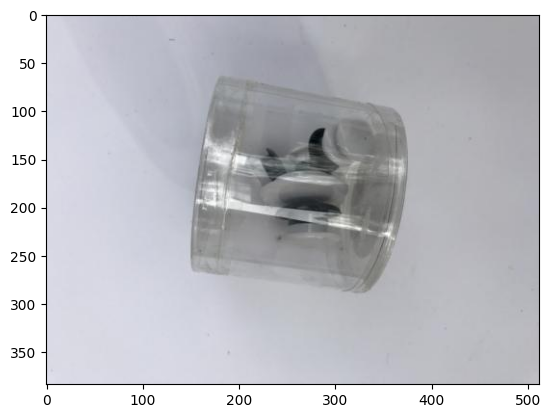


Correct Class : plastic385.jpg

Predicted Class : Plastic
Confidence : 99.0 %


Continue? (1/0) : 1

----------------------------------------------------------------------------------------------------------------------

Enter Test Image Index (Enter an Integer lesser than 407) : 100


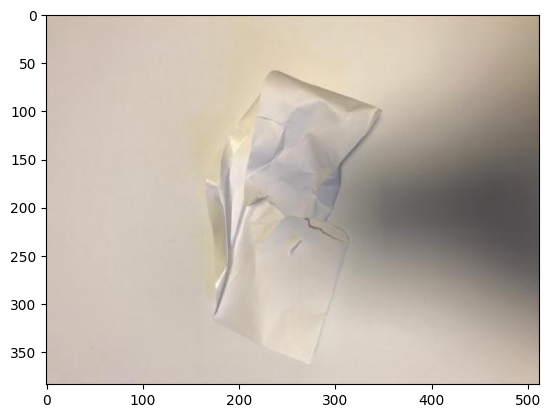


Correct Class : paper505.jpg

Predicted Class : Paper
Confidence : 85.0 %


Continue? (1/0) : 0

----------------------------------------------------------------------------------------------------------------------


In [10]:
l=["Cardboard", "Glass", "Metal", "Paper", "Plastic", "Mixed"]

flag = 1
try:
	os.chdir('predb')
except:
	os.chdir('.')
dirlist=os.listdir()
print(' ')
while flag==1:

	# Open Image and Directory
	imgdir=dirlist[int(input("\nEnter Test Image Index (Enter an Integer lesser than "+str(len(dirlist))+") : "))]
	img = imread(imgdir)

	# Display Image
	imshow(img)
	show()

	# Run Image Through CNN
	img = cv2.resize(img,(256,256))
	img = img.reshape((1,256,256,3))
	img = model.predict(img,verbose=0)
	img=img.reshape((6,))

	# Correct Class
	print("\nCorrect Class :", imgdir)

	# Prediction by CNN
	if np.amax(img)<(2.0/3):
		print("\nPredicted Class : Mixed")
		print("Confidence was too low, hence it's precautiously categorized under Mixed")
	else:
		print("\nPredicted Class :",l[int(np.where(img == np.amax(img))[0][0])])
		print("Confidence :",(np.amax(img)*100)//1, "%")

	flag=int(input("\n\nContinue? (1/0) : "))

	print("\n----------------------------------------------------------------------------------------------------------------------")